This tutorial focuses on preparing ***the power spectral density (PSD) estimated by seqARIMA noise subtraction filter***.

`beacon` will be aliased as `bc` in the code snippets.

In [1]:
import beacon as bc

/opt/miniconda3/envs/BEACON/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


# Loading GW data & preprocessing

## Load data
There are two data formats commonly used in GW data analysis: Frame format (.gwf) and HDF5 format (.h5 or .hdf5).
`beacon` package only supports HDF5 format for loading data at the moment, so GWF files need to be loaded using `gwpy` or `pycbc` package.
Here, **HDF5** format is used for demonstration.

In [ ]:
# Change these paths as your file directory!
H1_hdf5_path = "path/to/file_H1.hdf5"
L1_hdf5_path = "path/to/file_H1.hdf5"

strain_H1 = bc.IO.read_H5(H1_hdf5_path, sampling_freq=4096)
strain_L1 = bc.IO.read_H5(L1_hdf5_path, sampling_freq=4096)

In [3]:
type(strain_H1)

beacon.TS.ts

However, if you have GWF files, you can load it by `pycbc` or `gwpy` and then convert it to `beacon.TS.ts` class.
```python
from gwpy.timeseries import TimeSeries
from pycbc.frame import read_frame

gwpy_TS = TimeSeries.read(
    "path/to/gwf/file.gwf", channel="{channel_name}"
)
pycbc_TS = read_frame(
    "path/to/gwf/file.gwf", channels="{channel_name}"
)

# bc.TS.ts() or bc.ts()
ts_from_gwpy = bc.ts.from_gwpy(gwpy_TS)
ts_from_pycbc = bc.ts.from_pycbc(pycbc_TS)
```

## Crop data

For estimating PSD using seqARIMA, it would be better if seqARIMA model fits avoiding the signal time segments.

In [ ]:
tgps = 100000000 # Change this!
dur = 32
tstart = int(tgps) - 56 # 56 seconds before the reported gps time (tgps)
tend = tstart + dur  # -56 + 32 = 24 seconds before  the reported gps time (tgps)

noise_H1_win = strain_H1.window(tstart, tend)
noise_L1_win = strain_L1.window(tstart, tend)

strain_H1_win = strain_H1.window(int(tgps) - 16, int(tgps) + 16)
strain_L1_win = strain_L1.window(int(tgps) - 16, int(tgps) + 16)


Here, the noise PSD is affected by the time segment configuration, e.g., starting time, end time, druation. 
The coventional way using Welch method also has the same issue, but it try to mitigate the effect by averaging many segments from LONG enough data.
In addition to the reason why FFT-based method needs LONG data, the frequency resolution is determined by the data duration.

On the other hand, seqARIMA can fit the model to SHORT data (e.g., ~4 seconds or even shorter) and estimate PSD with whatever the frequency resolution.
The main reason why it is possible is that seqARIMA is a parametric model, which leads to the *"modeled PSD"* rather than *"averaged PSD of data"*. 

Let's look at the data.

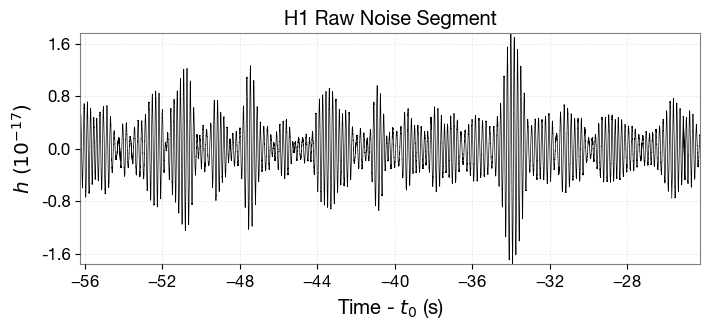

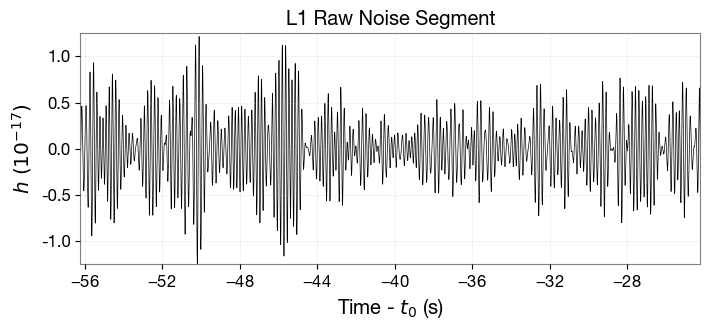

In [12]:
import matplotlib.pyplot as plt
bc.plot.plot_oscillo(
    noise_H1_win,
    tzero=tgps,
    title=f"H1 Raw Noise Segment",
)
plt.show()

bc.plot.plot_oscillo(
    noise_L1_win,
    tzero=tgps,
    title=f"L1 Raw Noise Segment",
)
plt.show()

# Apply seqARIMA

Here, one can try different set of parameters to fit seqARIMA model to the data.
In this demonstration, the following parameters are used:
- `(d, p_max, q_max) = (0, 8192, 3)`: set the maximum AR order to 4096 and EoA order to 3
- with `(fl,fu) = (16, 1024)` Hz in bandpass filter

Here, `q_max` indicates the maximum order of the Ensemble of Average (EoA) smoother. As a default, it ranges q from `1` to `q_max`, and then it performs single moving average (MA) smoothing with order `q` and averages the results for all `q` values. This approach helps to reduce the spectral leackage effect. Details can be found in the [seqARIMA paper](https://arxiv.org/abs/2404.05364).

For choosing `q_max`, it would be better to know what is our target signal frequency range. In this demonstration, we set `q_max=3` to avoid suppressing at $\lt$ 600 Hz.

The guideline for avoiding suppress the signal frequency range is given at the bottom of this tutorial (Appendix 1).

In [6]:
# Setting parameters 
d = None
p_max = 8192
q_max = 3 
low_freq_cutoff = 16 # Hz
upp_freq_cutoff = 1024 # Hz

# Fitting seqARIMA model to noise data
arm_noise_H1 = bc.seqARIMA.seqarima(
    noise_H1_win,
    d=d,
    p=p_max,
    q=range(1, q_max + 1),
    fl=low_freq_cutoff,
    fu=upp_freq_cutoff,
)
arm_noise_L1 = bc.seqARIMA.seqarima(
    noise_L1_win,
    d=d,
    p=p_max,
    q=range(1, q_max + 1),
    fl=low_freq_cutoff,
    fu=upp_freq_cutoff,
)


> Running seqarima...
> (2) Autoregressive stage
|> p=7734 selected!
> (3) Moving-average stage
|> q={ 1, 2, 3 } (collector: median)
> (4) Pass filter stage
|> Band-pass (FIR) filter applied: type=bandpass, order=512, cutoff=(16, 1024) Hz
> Running seqarima...
> (2) Autoregressive stage
|> p=5975 selected!
> (3) Moving-average stage
|> q={ 1, 2, 3 } (collector: median)
> (4) Pass filter stage
|> Band-pass (FIR) filter applied: type=bandpass, order=512, cutoff=(16, 1024) Hz


Then from the fitted seqARIMA model, meta information can be extracted: 
- selected d order 
- AR coefficents corresponding to the selected p
- variance estimated from the AR model

In [7]:
# Extract automatically chosen parameters
d_order_H1 = 0  # arm_noise_H1.diff_meta.d_order
d_order_L1 = 0  # arm_noise_L1.diff_meta.d_order

arcoef_H1 = arm_noise_H1.ar_meta.ar_coef
varpred_H1 = arm_noise_H1.ar_meta.var_pred
arcoef_L1 = arm_noise_L1.ar_meta.ar_coef
varpred_L1 = arm_noise_L1.ar_meta.var_pred

q_orders_H1 = arm_noise_H1.ma_meta.q_order
q_orders_L1 = arm_noise_L1.ma_meta.q_order

cutoff_H1 = arm_noise_H1.bp_meta.cutoff
cutoff_L1 = arm_noise_L1.bp_meta.cutoff

$^*$ Here, in this demonstration, we don't apply "Differencing", so `d=0`.

Then we are able to estimate PSD from the fitted seqARIMA model.

In [8]:
freq_H1, psd_H1 = bc.seqARIMA.psd_seqarima(
    N=32 * 4096,
    fs=4096,
    var_pred=varpred_H1,
    d=d_order_H1,
    ar_coef=arcoef_H1,
    q=q_orders_H1,
    fl=cutoff_H1[0],
    fu=cutoff_H1[1],
)
freq_L1, psd_L1 = bc.seqARIMA.psd_seqarima(
    N=32 * 4096,
    fs=4096,
    var_pred=varpred_L1,
    d=d_order_L1,
    ar_coef=arcoef_L1,
    q=q_orders_L1,
    fl=cutoff_H1[0],
    fu=cutoff_H1[1],
)

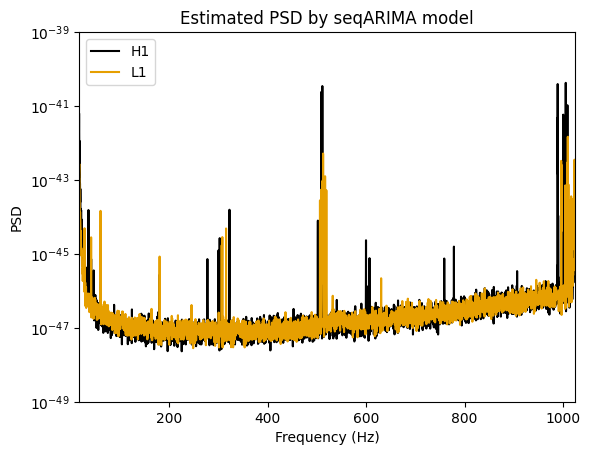

In [9]:
plt.plot(freq_H1, psd_H1, label="H1")
plt.plot(freq_L1, psd_L1, label="L1")
plt.xlim(16, 1024)
plt.ylim(1e-49, 1e-39)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Estimated PSD by seqARIMA model")
plt.legend()
plt.semilogy()
plt.show()

# Save data output

With delimiter of " " (space), the PSD data can be saved as a text file.

In [ ]:
import os
import pandas as pd
if not os.path.exists("Data/PSD"):
    os.makedirs("Data/PSD", exist_ok=True)

pd.DataFrame(psd_H1, freq_H1).to_csv("Data/PSD/PSD_H1_p8k_q3.dat", sep=" ", header=False)
pd.DataFrame(psd_L1, freq_L1).to_csv("Data/PSD/PSD_L1_p8k_q3.dat", sep=" ", header=False)

And also corresponding raw strain data (cropped with 32 seconds around the event time) can be saved as a gwf file.

In [ ]:
gwpy_ts_H1 = strain_H1_win.to_gwpy()
gwpy_ts_L1 = strain_L1_win.to_gwpy()

gwpy_ts_H1.name = "H1:GDS-CALIB_STRAIN_CLEAN"
gwpy_ts_L1.name = "L1:GDS-CALIB_STRAIN_CLEAN"

gwpy_ts_H1.write("Data/Strain_H1.gwf")
gwpy_ts_L1.write("Data/Strain_L1.gwf")


# Appendix

## Upper cutoff frequency of `MA(q)`
The upper cutoff frequency ($f_c$) of `MA(q)` is given by:
$$
f_c \approx \frac{0.443~f_s}{q_{\rm max}}
$$
where $f_s$ is the sampling frequency.
If you choose `q_max=3` with `f_s=4096` Hz, the upper cutoff frequency is approximately `f_c=636.0` Hz.
Please refer to the exact $f_c$ value table below for other `q_max` values.

| `q_max` | $f_c$ |
|---------|-------|
| 2       | 745.6 Hz |
| 3       | 636.0 Hz |
| 4       | 430.2 Hz |
| 5       | 369.3 Hz |
| 6       | 295.3 Hz |
| 7       | 261.5 Hz |
| 8       | 223.8 Hz |
| 9       | 202.7 Hz |
| 10       | 179.9 Hz |
